**Name** : Rasika Rajendra Ghadge

**Roll No** : BEITB91

**PRN** : 72139663B

**Class** : BE IT B

### Aim
Object detection using Transfer Learning of CNN 
architectures 
1. Load in a pre-trained CNN model trained on a large dataset 
2. Freeze parameters (weights) in model’s lower convolutional layers 
3. Add custom classifier with several layers of trainable parameters to model 
4. Train classifier layers on training data available for task 
5. Fine-tune hyper parameters and unfreeze more layers as needed 

Steps: 
1. load data
2. resizing image
3. proper format for labels
4. load vgg16 modle
5. base model should not train
6. preprocess input
7. build
8. compile
9. train model with early stopping
10. evaluate
11. predictions

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# pip install tfds-nightly==4.9.2

### Imports

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

### Load Data

In [5]:
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load("tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

### Image Preprocessing

In [6]:
## check existing image size
train_ds[0].shape

TensorShape([442, 1024, 3])

In [7]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

In [8]:
train_labels

<tf.Tensor: shape=(2569,), dtype=int64, numpy=array([2, 3, 3, ..., 0, 2, 0], dtype=int64)>

In [9]:
## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [10]:
train_labels[0]

array([0., 0., 1., 0., 0.], dtype=float32)

### Use Pretrained VGG16 Image Classification model

# **Load a pre-trained CNN model trained on a large dataset**

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [12]:
train_ds[0].shape

TensorShape([150, 150, 3])

In [13]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
# pre-trained weights from ImageNet.
#The include_top parameter is set to False to exclude the final classification layer, as you will add a custom classifier on top.

In [14]:
## will not train base mode
# Freeze Parameters in model's lower convolutional layers
base_model.trainable = False 

In [15]:
## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [16]:
## model details
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

**Add custom classifier with two dense layers of trainable parameters to model**

In [17]:
#add our layers on top of this model
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

**Train classifier layers on training data available for task**

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [19]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
#The code uses early stopping with a patience of 5 to monitor the validation accuracy and restore the best weights.

In [20]:
history=model.fit(train_ds, train_labels, epochs=3, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/3
65/65 [==============================] - 195s 3s/step - loss: 1.8946 - accuracy: 0.4701 - val_loss: 1.3044 - val_accuracy: 0.5720
Epoch 2/3
65/65 [==============================] - 195s 3s/step - loss: 0.8302 - accuracy: 0.6954 - val_loss: 1.1838 - val_accuracy: 0.6245
Epoch 3/3
65/65 [==============================] - 192s 3s/step - loss: 0.5449 - accuracy: 0.7976 - val_loss: 1.1063 - val_accuracy: 0.6693


In [21]:
los,accurac=model.evaluate(test_ds,test_labels)
print("Loss: ",los,"Accuracy: ", accurac)

35/35 [==============================] - 83s 2s/step - loss: 0.3871 - accuracy: 0.8610
Loss:  0.3871334195137024 Accuracy:  0.8610354065895081


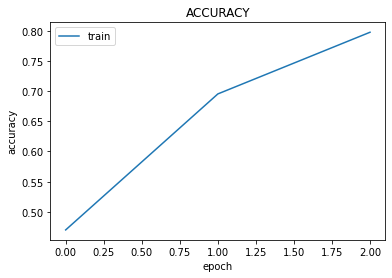

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

In [24]:
import numpy as np
import pandas as pd
y_pred = model.predict(test_ds)
y_classes = np.argmax(y_pred, axis=1)
# y_classes = [np.argmax(element) for element in y_pred]
# to_categorical(y_classes, num_classes=5)
# to_categorical(test_labels, num_classes=5)
# print(y_classes[:10])
# print("\nTest")
# print(test_labels[:10])

# Display the class labels for the first 10 test samples
print("Predictions:")
print(y_classes[:10])

# Display the true labels for the first 10 test samples
print("\nTrue Labels:")
true_labels = np.argmax(test_labels, axis=1)
print(true_labels[:10])

35/35 [==============================] - 83s 2s/step
Predictions:
[2 3 3 0 3 0 0 0 0 2]

True Labels:
[2 3 3 4 3 0 0 0 0 1]
